-----------
Initializing structure...
time for choose_chunkdivision = 0.000178099 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0347211 s
-----------
creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


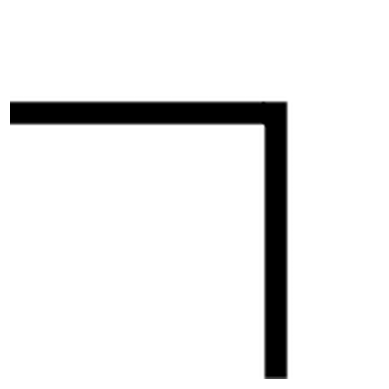

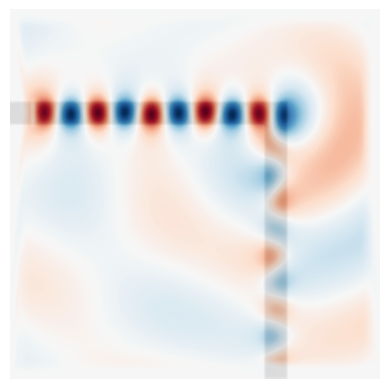

In [1]:
# meep waveguide
import meep as mp
import matplotlib.pyplot as plt

cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),
                    center=mp.Vector3(-2.5,-3.5),
                    material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                    center=mp.Vector3(3.5,2),
                    material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10

sources = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                    component=mp.Ez,
                    center=mp.Vector3(-7,-3.5),
                    size=mp.Vector3(0,1))]

sim = mp.Simulation(cell_size=cell, 
                    boundary_layers=pml_layers, 
                    geometry=geometry, 
                    sources=sources, 
                    resolution=resolution)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
        until=200)


eps_data = sim.get_array(center=mp.Vector3(), 
                        size=cell, 
                        component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

ez_data = sim.get_array(center=mp.Vector3(), 
                        size=cell, 
                        component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

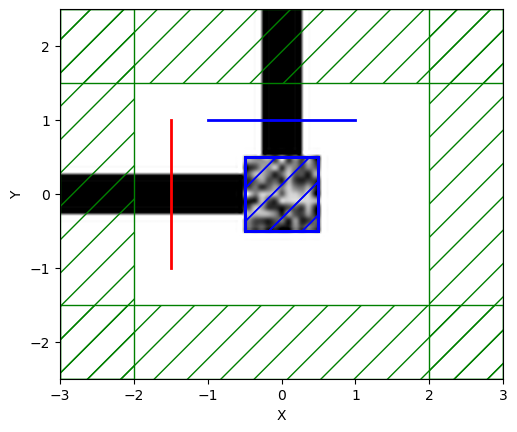

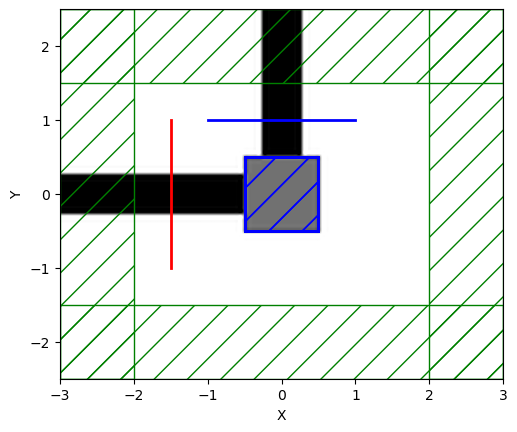

In [ ]:
# Adjoint optimization
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt

mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

resolution = 20

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

# source(Gaussian pulse)
fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [-1.5, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency = fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]
design_region_resolution = 10
Nx = design_region_resolution + 1
Ny = design_region_resolution + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(design_variables, 
                                volume=mp.Volume(center=mp.Vector3(), 
                                size=mp.Vector3(1, 1, 0))
                                )

geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx/4), 
        material=Si,
        size=mp.Vector3(Sx / 2, 0.5, 0)
    ),
    mp.Block(
        center=mp.Vector3(y=Sy/4),
        material=Si,
        size=mp.Vector3(0.5, Sy / 2, 0)
    ),
    mp.Block(
        center=design_region.center, 
        material=design_variables,
        size=design_region.size, 
    ),
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

TE_top =mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)),
    mode=1
)
ob_list = [TE_top]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

opt.plot2D(True, frequency=1 / 1.55)
plt.show()

x0 = 0.5 * np.ones((Nx * Ny, ))
opt.update_design([x0])

opt.plot2D(True)
plt.show()


In [21]:
evaluation_history = []
sensitivity = [0]

def f(x, grad):
    f0, dJ_du = opt([x])
    f0 = f0[0]
    if grad.size > 0:
        grad[:] = np.squeeze(dJ_du)
    evaluation_history.append(np.real(f0))
    sensitivity[0] = dJ_du
    return np.real(f0)

algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 10

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)

x = solver.optimize(x0)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


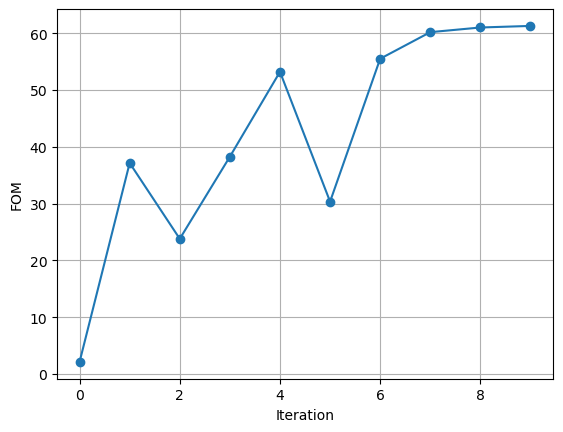

In [22]:
plt.figure()
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

(np.float64(-1.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0))

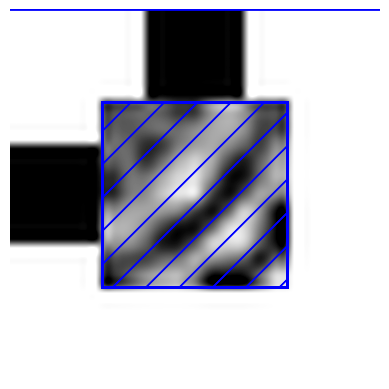

In [ ]:
opt.update_design([x])
opt.plot2D(
    True,
    plot_monitors_flag=False,
    output_plane=mp.Volume(center=(0,0,0), size=(2,2,0))
)
plt.axis("off")

In [15]:
TE0 = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(center=mp.Vector3(-1, 0, 0), size=mp.Vector3(x=2)),
    mode=1
)
ob_list = [TE0, TE_top]

def J(source, top):
    return npa.abs(top / source) ** 2

opt.objective_functions = [J]
opt.objective_arguments = ob_list
opt.update_design([x0])

evaluation_history = []
solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(x0)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


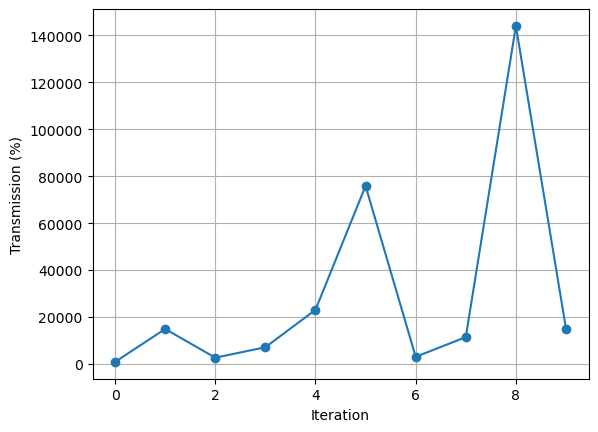

In [16]:
plt.figure()
plt.plot(np.array(evaluation_history) * 100, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Transmission (%)")
plt.show()